# IberLEF 2023 Task - PoliticEs. Political ideology detection in Spanish texts

Datasources:

[https://portal.odesia.uned.es/en/dataset/politices-2023](https://portal.odesia.uned.es/en/dataset/politices-2023)

[https://codalab.lisn.upsaclay.fr/competitions/10173#learn_the_details-get_starting_kit](https://codalab.lisn.upsaclay.fr/competitions/10173#learn_the_details-get_starting_kit)

Using Trainer class with CUDA parameters.

## 1. Load Dataset

In [2]:
from datasets import load_dataset, Dataset, DatasetDict

data_files = {"train": "data/development.csv", 
              "test": "data/development_test.csv"}
politic_dataset = load_dataset("csv", data_files=data_files)
politic_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet'],
        num_rows: 14400
    })
    test: Dataset({
        features: ['label', 'gender', 'profession', 'ideology_binary', 'ideology_multiclass', 'tweet'],
        num_rows: 3600
    })
})

In order to understand the data, we can perform EDA (Exploratory Data Analysis) on the dataset using Pandas.

In [3]:
df_train = politic_dataset["train"].to_pandas()
df_test = politic_dataset["test"].to_pandas()

In [32]:
df_train.head()

,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user Escribió un libro resultón, con gracejo,..."
1,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,@user Lo prometido es deuda. Aquí la foto: .
2,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,@user Bastante ñoña. Me jarté a llorar. De lo ...
3,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user No sé nada acerca de eso, pero está clar..."
4,00369358fac3b8d42845f82f0c3ececc,male,journalist,left,left,"@user ¿En qué medio tienen su podcast esos, di..."


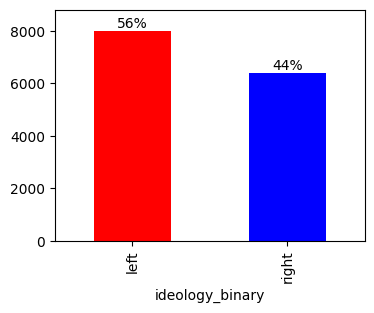

In [5]:
counts = df_train.ideology_binary.value_counts()
max_value = counts.max() * 1.1  # Add some space above the highest bar
percentages = counts / counts.sum() * 100

ax = df_train.ideology_binary.value_counts().plot(kind="bar",
                                                  figsize=(4,3), 
                                                  ylim=(0, max_value),
                                                  color=['red', 'blue'])
# Add percentage labels
for i, (count, pct) in enumerate(zip(counts, percentages)):
    ax.text(i, count, f'{pct:.0f}%', ha='center', va='bottom', fontsize=10)


In [28]:
df_train.head().to_markdown()

'|    | label                            | gender   | profession   | ideology_binary   | ideology_multiclass   | tweet                                                                                                                                                                                                                                                                                       |\n|---:|:---------------------------------|:---------|:-------------|:------------------|:----------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|\n|  0 | 00369358fac3b8d42845f82f0c3ececc | male     | journalist   | left              | left                  | @user Escribió un libro resultón, con gracejo, que mueve sentimientos por doquier. La inv

This distribution shows a slight imbalance ($56/46$), which is not severe enough to produce a low F1-score.

## 2. Load Model and Tokenizer

In [ ]:
import numpy as np
import torch
from transformers import (
    AutoTokenizer, # For tokenization
    DataCollatorWithPadding, # For dynamic padding
    AutoModelForSequenceClassification, # For loading pre-trained model
    TrainingArguments, # For setting training arguments
    Trainer # Transformer Trainer class
)

torch.cuda.empty_cache()
checkpoint = "dccuchile/bert-base-spanish-wwm-cased"
model_name = checkpoint.split("/")[-1]
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_length = 128 # For comparison with Robertuito model

In [ ]:
from dotenv import load_dotenv
import wandb

load_dotenv(".env")  # Load environment variables WANDB_API_KEY 
wandb.init(project="transformers-fine-tuning", name=f"politicES-{model_name}")

True

## 3. Define the Classification Task and Labels
The target column is **'ideology_binary'**. We need to map the labels to IDs,
where 'ideology_binary' has two classes: 'left' and 'right'.


In [9]:
# Define the label mappings 
label_to_id = {"left": 0, "right": 1}
id_to_label = {v: k for k, v in label_to_id.items()}
num_labels = len(label_to_id)

# Load the model with the correct number of labels
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We receive a warning because the choosed model has not been pretrained on classifying texts, the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead.


The **'label'** column is usually the one used by the Trainer, 
so we will map the target column **'ideology_binary'** to **'label'**. In the PoliticES dataset the **'label'** column corresponds to an id of the tweet, so we have to rename it. 

Moreover, the parameter **remove_unused_columns** of the Trainer class defaults to True, we don't need to take care of removing the columns unused by the model forward method.

In [10]:
# dataset = politic_dataset.remove_columns(['label', 'gender', 'profession',  'ideology_multiclass'])
politic_dataset = politic_dataset.rename_column("label", "id")
politic_dataset = politic_dataset.rename_column("ideology_binary", "label")

In [11]:
politic_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'gender', 'profession', 'label', 'ideology_multiclass', 'tweet'],
        num_rows: 14400
    })
    test: Dataset({
        features: ['id', 'gender', 'profession', 'label', 'ideology_multiclass', 'tweet'],
        num_rows: 3600
    })
})

In [ ]:
# Preprocessing function
def tokenize_and_encode_labels(examples):
    # Tokenize the input text (tweet)
    tokenized_inputs = tokenizer(
        examples["tweet"], 
        truncation=True
    )
    
    # Map the political ideology string label to an integer ID for training
    tokenized_inputs["label"] = [label_to_id[label] for label in examples["label"]]
    
    return tokenized_inputs

# Apply the preprocessing function to the dataset
tokenized_dataset = politic_dataset.map(tokenize_and_encode_labels, batched=True) 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Dynamic padding
tokenized_dataset.set_format("torch")

In [15]:
tokenized_dataset["train"].features

{'id': Value('string'),
 'gender': Value('string'),
 'profession': Value('string'),
 'label': Value('int64'),
 'ideology_multiclass': Value('string'),
 'tweet': Value('string'),
 'input_ids': List(Value('int32')),
 'token_type_ids': List(Value('int8')),
 'attention_mask': List(Value('int8'))}

## 4. Define Evaluation Metrics

Precission measures how many of the samples predicted as positive are actually positive:

$Precision = \frac{TP}{TP+FP}$

Recall measures how many of the positive samples are captured by the positive samples are captured by the positive predictions:

$Recall = \frac{TP}{TP+FN}$

And one way to summarize both metrics is the f1-score, which is the armonic mean of precission and recall:

$F1 = 2 \times \large \frac{precision\times recall}{precision + recall}$

In [16]:
import numpy as np
import evaluate

# Load the necessary metrics from the 'evaluate' library
# We can load the standard 'precision', 'recall', and 'f1' metrics once
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    """
    Compute precision, recall, and F1 macro score for a Hugging Face Trainer.

    Args:
        eval_pred (EvalPrediction): A tuple (predictions, labels) provided by Trainer.

    Returns:
        dict: A dictionary with 'precision', 'recall', and 'f1-macro' metrics.
    """
    # The EvalPrediction object contains (predictions, label_ids)
    logits, labels = eval_pred 

    # 1. Convert logits to class predictions
    # Predictions are the index of the highest logit value across the class axis (-1)
    predictions = np.argmax(logits, axis=-1)

    # 2. Compute the metrics using the macro average
    
    # F1 Score
    f1_result = metric_f1.compute(predictions=predictions, references=labels, average="macro")
    
    # Precision
    precision_result = metric_precision.compute(predictions=predictions, references=labels, average="macro")
    
    # Recall
    recall_result = metric_recall.compute(predictions=predictions, references=labels, average="macro")
    
    # 3. Return the results dictionary
    return {
        "precision": precision_result["precision"],
        "recall": recall_result["recall"],
        "f1-macro": f1_result["f1"],
    }


## 5. Configure Trainer



In [17]:
from transformers import TrainingArguments, EarlyStoppingCallback


output_dir = f"./results_{model_name}"

training_args = TrainingArguments(
    output_dir=output_dir,                # Output directory
    num_train_epochs=5,                   # Total number of training epochs
    per_device_train_batch_size=32,       # Batch size per device during training
    per_device_eval_batch_size=32,        # Batch size for evaluation
    fp16=True,                            # Use mixed precision
    eval_strategy="epoch",                # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,          # Load the best model found during training
    metric_for_best_model="eval_loss",    # Metric to track for best model
    disable_tqdm=False,                   # Enable tqdm progress bars
    report_to="wandb"                     # Report metrics to Weights & Biases
) 

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)]
)


In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-macro
1,No log,0.632238,0.638366,0.641435,0.638101
2,0.625800,0.657227,0.670474,0.671647,0.670965
3,0.405200,0.892768,0.655356,0.647217,0.648764
4,0.165300,1.625522,0.661496,0.663006,0.662066


TrainOutput(global_step=1800, training_loss=0.3447630596160889, metrics={'train_runtime': 299.7589, 'train_samples_per_second': 240.193, 'train_steps_per_second': 7.506, 'total_flos': 2339419059851520.0, 'train_loss': 0.3447630596160889, 'epoch': 4.0})

In [21]:
dir(trainer)

['__backends',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_determine_best_metric',
 '_evaluate',
 '_finish_current_push',
 '_fsdp_qlora_plugin_updates',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_dataloader',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_callback_state',
 '_load_from_checkpoint',
 

In [24]:
trainer.evaluate(eval_dataset=tokenized_dataset["test"])

{'eval_loss': 0.6322383880615234,
 'eval_precision': 0.6383659903599292,
 'eval_recall': 0.6414347165991903,
 'eval_f1-macro': 0.6381009141921545,
 'eval_runtime': 3.6098,
 'eval_samples_per_second': 997.286,
 'eval_steps_per_second': 31.304,
 'epoch': 4.0}

In [ ]:
results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])

for key, value in results.items():
    print(f"{key}: {value:0.4f}")

eval_loss: 0.6322
eval_precision: 0.6384
eval_recall: 0.6414
eval_f1-macro: 0.6381
eval_runtime: 3.7007
eval_samples_per_second: 972.7890
eval_steps_per_second: 30.5350
epoch: 4.0000


: 